```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install --upgrade tqdm
!pip install parameter-sherpa

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL")

torch.__version__

'1.3.1'

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
path = "drive/My Drive/AML/"
#path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [0]:
#df.head()

In [0]:
#plt.figure(figsize=(15,5))
#count = pd.DataFrame(df[['profile_id']].groupby('profile_id').size()).reset_index()
#count.columns = ["profile_id", "total"]
#sns.barplot(count.profile_id,count.total)
#plt.show()

In [0]:
#count

In [0]:
#plt.plot(df[df.profile_id==56].pm)
#plt.show()

In [0]:
df_sep = [df[df
          .profile_id==profile]
          .drop(['profile_id','torque','stator_yoke',
                 'stator_tooth','stator_winding'],axis=1)
          .reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)

class CNN_Net_2(nn.Module):
    def __init__(self, batch, in_c, out, 
                 filtro1, filtro2,
                 lag, 
                 neuroni1,
                 kernel1, kernel2, kernel3, kernel4, 
                 #padding1, padding2, padding3, padding4, 
                 stride1, stride2, stride3, stride4):
        super(CNN_Net_2, self).__init__()
        self.batch_size = 1
        self.in_c = in_c
        l0 = lag
        l1 = outputSize(l0,kernel1,stride1,0)
        l2 = outputSize(l1,kernel2,stride2,0)
        l3 = outputSize(l2,kernel3,stride3,0)
        l4 = outputSize(l3,kernel4,stride4,0)
        #print(l4)

        self.conv1 = nn.Conv1d(in_channels= in_c, 
                               out_channels= filtro1, 
                               kernel_size= kernel1,
                               stride= stride1,
                               padding=0)    
        self.pool1 = nn.MaxPool1d(kernel2,stride=stride2,padding=0) 
        self.conv2 = nn.Conv1d(filtro1,filtro2,kernel3,stride=stride3,padding=0)
        self.pool2 = nn.MaxPool1d(kernel4,stride=stride4,padding=0)
        self.fc1 = nn.Linear(filtro2*l4, neuroni1)
        self.fc2 = nn.Linear(neuroni1, out)

    def forward(self, x):
        batch_size, _, _ = x.shape
        x =  self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(batch_size, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) 
        return  self.fc2(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features

In [9]:
l0 = 60
l1 = outputSize(l0,5,2,0)
l2 = outputSize(l1,5,2,0)
l3 = outputSize(l2,5,2,0)
l4 = outputSize(l3,5,2,0)
print(l1,l2,l3,l4)

28 12 4 1


In [0]:
def sliding_window(dataset, target_var, inp, out, shuffle=True):
    while True:
        for X in dataset:
            target = X[[target_var]]
            num_features = len(X.columns)
            
            indice = list(range(inp + out, X.shape[0]))
            
            if shuffle:
                np.random.shuffle(indice)
            for i in indice:
                features = X.iloc[i-inp-out:i-out,].values.reshape(inp,num_features)
                pred = target.iloc[i:i+out]

                yield np.array(features), np.array(pred)

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7]

In [0]:
def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)

        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out), FEATURES + TARGET]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'stator_yoke','stator_tooth',
                                                                                  'stator_winding'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'stator_yoke','stator_tooth',
                                                                                  'stator_winding'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
#df_train[0]

In [0]:
parameters = [sherpa.Continuous('lr',[0.00005,0.05]),
              #sherpa.Choice('lag',[60,100,200,500,1000]),
              sherpa.Discrete('filtro1',[10,500]),
              sherpa.Discrete('filtro2',[10,500]),
              sherpa.Discrete('neuroni1',[10,1000]),
              sherpa.Discrete('kernel1',[1,5]),
              sherpa.Discrete('kernel2',[1,5]),
              sherpa.Discrete('kernel3',[1,5]),
              sherpa.Discrete('kernel4',[1,5]),
              sherpa.Discrete('stride1',[1,2]),
              sherpa.Discrete('stride2',[1,2]),
              sherpa.Discrete('stride3',[1,2]),
              sherpa.Discrete('stride4',[1,2]),
              #sherpa.Discrete('padding1',[0,1]),
              #sherpa.Discrete('padding2',[0,1]),
              #sherpa.Discrete('padding3',[0,1]),
              #sherpa.Discrete('padding4',[0,1]),
              sherpa.Choice('batch_size',[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
best_score = 99999
feature    = 8

for trial in study:

    look_back  = 60 #int(trial.parameters["lag"])

    lstm = CNN_Net_2(batch=int(trial.parameters["batch_size"]),
                     in_c=feature,
                     out = 1,
                     lag = 60, #int(trial.parameters["lag"])
                     filtro1=int(trial.parameters["filtro1"]),
                     filtro2=int(trial.parameters["filtro2"]),
                     neuroni1=int(trial.parameters["neuroni1"]),
                     kernel1=int(trial.parameters["kernel1"]),
                     kernel2=int(trial.parameters["kernel2"]),
                     kernel3=int(trial.parameters["kernel3"]),
                     kernel4=int(trial.parameters["kernel4"]),
                     stride1=int(trial.parameters["stride1"]),
                     stride2=int(trial.parameters["stride2"]),
                     stride3=int(trial.parameters["stride3"]),
                     stride4=int(trial.parameters["stride4"]),
                     #padding1=int(trial.parameters["padding1"]),
                     #padding2=int(trial.parameters["padding2"]),
                     #padding3=int(trial.parameters["padding3"]),
                     #padding4=int(trial.parameters["padding4"])
                     ).to(device)
                     
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    #gen = sliding_window(df_train, "pm", look_back, 1)
    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                #gen = sliding_window(df_train, "pm", look_back, 1)
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, 8, look_back)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            #loss = loss_fn(output.view(-1), y_batch.view(-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        if len(losses)>10000:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses[-1000,]),7)))
        else:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),7)))

    #test_gen = sliding_window(df_val, "pm", look_back, 1)
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, 8, look_back)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        #print(x_test_batch.shape)
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_cnn")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN.csv")

Epoch:753 Loss:50.5553527: 100%|██████████| 753/753 [00:34<00:00, 22.12it/s]


New Challanger with MSE on val: 0.0011691224890032627 and confs: {'lr': 0.014746477668561608, 'filtro1': 406, 'filtro2': 46, 'neuroni1': 611, 'kernel1': 1, 'kernel2': 1, 'kernel3': 2, 'kernel4': 3, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 1024}


Epoch:347 Loss:88682.0177214:  92%|█████████▏| 347/377 [00:40<00:03,  8.49it/s]

something strange happened
(2048, 8, 60)
torch.Size([2048, 8, 60])
You somehow created an exception hahaha!


RuntimeError: ignored

In [0]:
best_model = torch.load(path + "models/best_model_cnn")
results = pd.read_csv(path + "results/AutoML_CNN.csv")
results = results[results["Status"]=="COMPLETED"]

In [0]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
test_gen = dataloader([df_test[0].values], look_back, shuffle=False)

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, df_test[0].shape[0], batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 8, look_back)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

In [0]:
y_test = np.array(y_test).reshape(-1)
#print(y_test.shape)
plt.figure(figsize=(10,10))
plt.plot(y_test[-10000:])
plt.plot(y_pred_all[-10000:])

plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

In [0]:
def new_loss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1)*F.relu(target - 0.5)
        return torch.mean(weights*((output - target)**2))
    
    return high_low_loss

In [0]:
parameters = [sherpa.Continuous('lr',[0.00005,0.05]),
              sherpa.Discrete('lag',[10,1000]),
              sherpa.Discrete('filtro1',[10,500]),
              sherpa.Discrete('filtro2',[10,500]),
              sherpa.Discrete('neuroni1',[10,1000]),
              sherpa.Discrete('kernel1',[1,5]),
              sherpa.Discrete('kernel2',[1,5]),
              sherpa.Discrete('kernel3',[1,5]),
              sherpa.Discrete('kernel4',[1,5]),
              sherpa.Discrete('stride1',[1,2]),
              sherpa.Discrete('stride2',[1,2]),
              sherpa.Discrete('stride3',[1,2]),
              sherpa.Discrete('stride4',[1,2]),
              #sherpa.Discrete('padding1',[0,1]),
              #sherpa.Discrete('padding2',[0,1]),
              #sherpa.Discrete('padding3',[0,1]),
              #sherpa.Discrete('padding4',[0,1]),
              sherpa.Choice('batch_size',[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
best_score = 99999
feature    = 8

for trial in study:

    look_back  = 60 #int(trial.parameters["lag"])

    lstm = CNN_Net_2(batch=int(trial.parameters["batch_size"]),
                     in_c=feature,
                     out = 1,
                     lag = 60,
                     filtro1=int(trial.parameters["filtro1"]),
                     filtro2=int(trial.parameters["filtro2"]),
                     neuroni1=int(trial.parameters["neuroni1"]),
                     kernel1=int(trial.parameters["kernel1"]),
                     kernel2=int(trial.parameters["kernel2"]),
                     kernel3=int(trial.parameters["kernel3"]),
                     kernel4=int(trial.parameters["kernel4"]),
                     stride1=int(trial.parameters["stride1"]),
                     stride2=int(trial.parameters["stride2"]),
                     stride3=int(trial.parameters["stride3"]),
                     stride4=int(trial.parameters["stride4"]),
                     #padding1=int(trial.parameters["padding1"]),
                     #padding2=int(trial.parameters["padding2"]),
                     #padding3=int(trial.parameters["padding3"]),
                     #padding4=int(trial.parameters["padding4"])
                     ).to(device)
                     
    losses = []
    criterion = new_loss(1,3)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                #gen = sliding_window(df_train, "pm", look_back, 1)
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, 8, look_back)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        if len(losses)>10000:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses[-1000,]),7)))
        else:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),7)))

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, 8, look_back)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_cnn_newLoss")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_newLoss.csv")

In [0]:
best_model = torch.load(path + "models/best_model_cnn_newLoss")
results = pd.read_csv(path + "results/AutoML_CNN_newLoss.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back = 60
test_gen = dataloader([df_test[0].values], look_back, shuffle=False)

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, df_test[0].shape[0], batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 8, look_back)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

In [0]:
y_test = np.array(y_test).reshape(-1)
plt.figure(figsize=(10,10))
plt.plot(y_test[-10000:])
plt.plot(y_pred_all[-10000:])

plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

STATOR

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque','pm'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7,8,9]

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
parameters = [sherpa.Continuous('lr',[0.00005,0.05]),
              #sherpa.Choice('lag',[60,100,200,500,1000]),
              sherpa.Discrete('filtro1',[10,500]),
              sherpa.Discrete('filtro2',[10,500]),
              sherpa.Discrete('neuroni1',[10,1000]),
              sherpa.Discrete('kernel1',[1,5]),
              sherpa.Discrete('kernel2',[1,5]),
              sherpa.Discrete('kernel3',[1,5]),
              sherpa.Discrete('kernel4',[1,5]),
              sherpa.Discrete('stride1',[1,2]),
              sherpa.Discrete('stride2',[1,2]),
              sherpa.Discrete('stride3',[1,2]),
              sherpa.Discrete('stride4',[1,2]),
              #sherpa.Discrete('padding1',[0,1]),
              #sherpa.Discrete('padding2',[0,1]),
              #sherpa.Discrete('padding3',[0,1]),
              #sherpa.Discrete('padding4',[0,1]),
              sherpa.Choice('batch_size',[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [28]:
look_back = 60
best_score = 99999
feature = 10

for trial in study:

    lstm = CNN_Net_2(batch=int(trial.parameters["batch_size"]),
                     in_c=feature,
                     out = 3,
                     lag = 60,
                     filtro1=int(trial.parameters["filtro1"]),
                     filtro2=int(trial.parameters["filtro2"]),
                     neuroni1=int(trial.parameters["neuroni1"]),
                     kernel1=int(trial.parameters["kernel1"]),
                     kernel2=int(trial.parameters["kernel2"]),
                     kernel3=int(trial.parameters["kernel3"]),
                     kernel4=int(trial.parameters["kernel4"]),
                     stride1=int(trial.parameters["stride1"]),
                     stride2=int(trial.parameters["stride2"]),
                     stride3=int(trial.parameters["stride3"]),
                     stride4=int(trial.parameters["stride4"]),
                     #padding1=int(trial.parameters["padding1"]),
                     #padding2=int(trial.parameters["padding2"]),
                     #padding3=int(trial.parameters["padding3"]),
                     #padding4=int(trial.parameters["padding4"])
                     ).to(device)
                         
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    #gen = sliding_window(df_train, "pm", look_back, 1)
    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = tqdm(range(0, df_length, batch_size))

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                #gen = sliding_window(df_train, "pm", look_back, 1)
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, 10, look_back)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(batch_size,-1), y_batch.view(batch_size,-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        if len(losses)>10000:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses[-1000,]),7)))
        else:
            progress_bar.set_description("Epoch:"+str(int(b/batch_size)+1)+" Loss:"+str(round(np.mean(losses),7)))

    #test_gen = sliding_window(df_val, "pm", look_back, 1)
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, 10, look_back)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_cnn_stator")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_stator.csv")

Epoch:1506 Loss:4545207.0141403: 100%|██████████| 1506/1506 [01:02<00:00, 24.21it/s]


New Challanger with MSE on val: 0.05046101952359372 and confs: {'lr': 0.04020908878205628, 'filtro1': 424, 'filtro2': 492, 'neuroni1': 671, 'kernel1': 4, 'kernel2': 2, 'kernel3': 4, 'kernel4': 1, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 512}


  0%|          | 0/377 [00:00<?, ?it/s]

New Challanger with MSE on val: 0.001292594563946028 and confs: {'lr': 0.04207531413921109, 'filtro1': 435, 'filtro2': 228, 'neuroni1': 733, 'kernel1': 2, 'kernel2': 2, 'kernel3': 3, 'kernel4': 1, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 1024}


Epoch:753 Loss:12.4023711: 100%|██████████| 753/753 [00:41<00:00,  7.88it/s]


New Challanger with MSE on val: 0.0004569198084483304 and confs: {'lr': 0.009891211010298799, 'filtro1': 419, 'filtro2': 368, 'neuroni1': 94, 'kernel1': 3, 'kernel2': 4, 'kernel3': 1, 'kernel4': 4, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 1024}


Epoch:753 Loss:3633.5837181: 100%|██████████| 753/753 [00:55<00:00,  6.87it/s]


New Challanger with MSE on val: 0.00023555606229299107 and confs: {'lr': 0.012602690285718808, 'filtro1': 428, 'filtro2': 412, 'neuroni1': 734, 'kernel1': 2, 'kernel2': 1, 'kernel3': 3, 'kernel4': 2, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 1024}


Epoch:3012 Loss:0.0016078: 100%|██████████| 3012/3012 [00:33<00:00, 91.19it/s]


New Challanger with MSE on val: 0.00013121983663199322 and confs: {'lr': 0.002747482804628746, 'filtro1': 453.0, 'filtro2': 386.0, 'neuroni1': 120.0, 'kernel1': 4.0, 'kernel2': 5.0, 'kernel3': 1.0, 'kernel4': 1.0, 'stride1': 1.0, 'stride2': 2.0, 'stride3': 2.0, 'stride4': 2.0, 'batch_size': 256.0}


Epoch:3012 Loss:663.2026456: 100%|██████████| 3012/3012 [00:43<00:00, 68.49it/s]


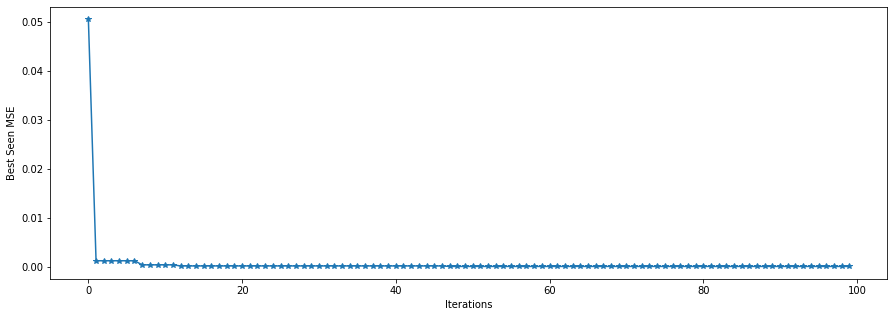

In [14]:
best_model = torch.load(path + "models/best_model_cnn_stator")
results = pd.read_csv(path + "results/AutoML_CNN_stator.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back=60
test_gen = dataloader([df_test[0].values], look_back, shuffle=False)

batch_size = 510

y_test = []
#y_pred_all = []
for x in range(0, df_test[0].shape[0], batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 10, look_back)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)
    if x==0:
        y_pred_all = y_pred.cpu().detach().numpy()
    else:
        y_pred_all = np.concatenate((y_pred_all,y_pred.cpu().detach().numpy()))

y_test = np.array(y_test).reshape(-1,3)

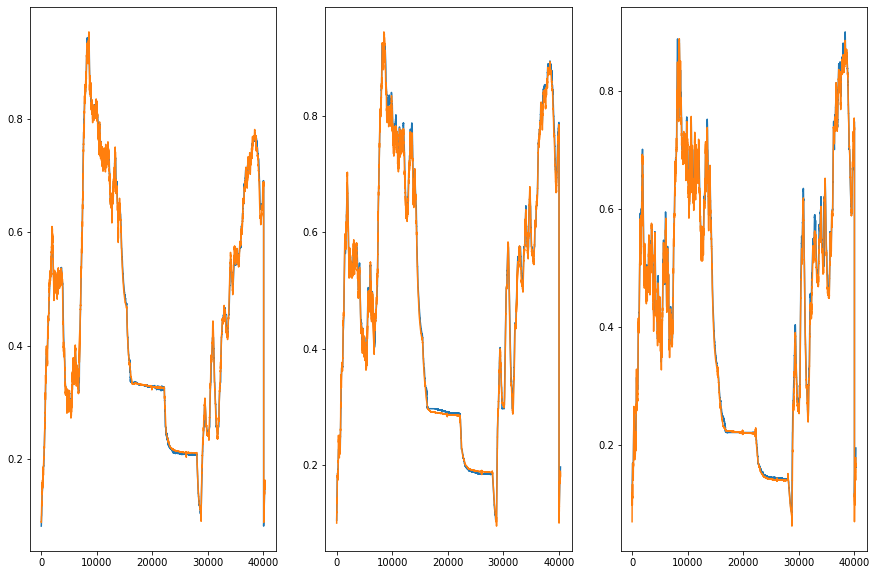

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(131)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(132)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(133)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])
plt.show()

In [25]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test))) #MAPE

0.01906875805942185